In [1]:
import logging
import os

import cabinetry

We start by configuring the output from `cabinetry` and suppress output from `matplotlib`. 
This customization is optional and has no impact on the functionality.

In [2]:
logging.basicConfig(
    level=logging.INFO, format="%(levelname)s - %(name)s - %(message)s"
)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

## The configuration file

The configuration file is the central place to configure `cabinetry`.
Let's have a look at the example configuration file used in this notebook.

In [3]:
cabinetry_config = cabinetry.configuration.read("config_example.yml")
cabinetry.configuration.print_overview(cabinetry_config)

INFO - cabinetry.configuration - opening config file config_example.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   3 Systematic(s)


The configuration file is split into four different blocks of settings. There are general settings:

In [4]:
cabinetry_config["General"]

{'Measurement': 'minimal_example',
 'POI': 'Signal_norm',
 'HistogramFolder': 'histograms/'}

The list of phase space regions (channels), in this case we are considering just a single one:

In [5]:
cabinetry_config["Regions"]

[{'Name': 'Signal_region',
  'Variable': 'jet_pt',
  'Filter': 'lep_charge > 0',
  'Binning': [200, 300, 400, 500, 600]}]

A list of samples, including data:

In [6]:
cabinetry_config["Samples"]

[{'Name': 'Data',
  'Tree': 'pseudodata',
  'Path': 'ntuples/data.root',
  'Data': True},
 {'Name': 'Background',
  'Tree': 'background',
  'Path': 'ntuples/prediction.root',
  'Weight': 'weight'},
 {'Name': 'Signal',
  'Tree': 'signal',
  'Path': 'ntuples/prediction.root',
  'Weight': 'weight'}]

A list of normalization factors:

In [7]:
cabinetry_config["NormFactors"]

[{'Name': 'Signal_norm', 'Samples': 'Signal', 'Nominal': 1, 'Bounds': [0, 5]}]

And finally a list of systematic uncertainties. In this case there are three systematic uncertainties:

In [8]:
cabinetry_config["Systematics"]

[{'Name': 'Luminosity',
  'Up': {'Normalization': 0.05},
  'Down': {'Normalization': -0.05},
  'Samples': ['Signal', 'Background'],
  'Type': 'Normalization'},
 {'Name': 'Modeling',
  'Up': {'Path': 'ntuples/prediction.root', 'Tree': 'background_varied'},
  'Down': {'Symmetrize': True},
  'Samples': 'Background',
  'Type': 'NormPlusShape'},
 {'Name': 'WeightBasedModeling',
  'Up': {'Weight': 'weight_up'},
  'Down': {'Weight': '0.7*weight'},
  'Samples': 'Background',
  'Type': 'NormPlusShape'}]

Regions, samples, normalization factors and systematics all can be identified by their names.

## Creating template histograms

We use the `template_builder` module to create all histograms needed to build the workspace defined in the configuration file.

In [9]:
cabinetry.template_builder.create_histograms(cabinetry_config, method="uproot")

WARNING - cabinetry.histo - Signal_region_Signal_nominal has empty bins: [0]


The histograms are saved to the folder specified under `HistogramFolder` in the `General` settings in the configuration file.
In this case, this folder is `histograms/`:

In [10]:
!ls histograms/

Signal_region_Background_Modeling_Up.npz
Signal_region_Background_WeightBasedModeling_Down.npz
Signal_region_Background_WeightBasedModeling_Up.npz
Signal_region_Background_nominal.npz
Signal_region_Data_nominal.npz
Signal_region_Signal_nominal.npz


It can be useful to apply additional post-processing after building template histograms.
Such processing can for example replace ill-defined statistical uncertainties in empty bins by zero.
It is performed via the `template_postprocessor` module:

In [11]:
cabinetry.template_postprocessor.run(cabinetry_config)

WARNING - cabinetry.histo - Signal_region_Signal_nominal has empty bins: [0]


New histograms have now appeard in the `histograms/` folder.
These "modified" histograms include the changes applied by the postprocessor.

In [12]:
!ls histograms/

Signal_region_Background_Modeling_Up.npz
Signal_region_Background_Modeling_Up_modified.npz
Signal_region_Background_WeightBasedModeling_Down.npz
Signal_region_Background_WeightBasedModeling_Down_modified.npz
Signal_region_Background_WeightBasedModeling_Up.npz
Signal_region_Background_WeightBasedModeling_Up_modified.npz
Signal_region_Background_nominal.npz
Signal_region_Background_nominal_modified.npz
Signal_region_Data_nominal.npz
Signal_region_Data_nominal_modified.npz
Signal_region_Signal_nominal.npz
Signal_region_Signal_nominal_modified.npz


## Workspace building

Next, we build a `pyhf` workspace and serialize it to a file.
The `workspace` module takes care of this task.

In [13]:
workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)

INFO - cabinetry.workspace - building workspace
INFO - pyhf.workspace - Validating spec against schema: workspace.json


## Fitting

With the workspace build, we can perform a maximum likelihood fit.
The results for the free parameters in the fit are reported.

In [14]:
ws = cabinetry.workspace.load(workspace_path)
bestfit, uncertainty, labels, _, corr_mat = cabinetry.fit.fit(ws)

INFO - cabinetry.fit - performing unconstrained fit
INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier staterror_Signal_region (4 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Luminosity (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Modeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier WeightBasedModeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - cabinetry.fit - staterror_Signal_region[bin_0]: 1.001249 +/- 0.041128
INFO - cabinetry.fit - staterror_Signal_region[bin_1]: 0.989030 +/- 0.038068
INFO - cabinetry.fit - staterror_Signal_region[bin_2]: 1.019662 +/- 0.036508
INFO - cabinetry.fit - staterror_Signal_region[bin_3]: 0.983094 +/- 0.042498
INFO - cabinetry.fit - Luminosity                    : -0.085397 +/- 0.987245
INFO - cabinetry.fit - Modeling             

------------------------------------------------------------------
| FCN = 17.2                    |     Ncalls=325 (325 total)     |
| EDM = 6.51e-06 (Goal: 0.0002) |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


We can also visualize the fit results.
Below are the pulls and the correlation matrix.
(The parameters for MC statistical uncertainty are currently included, but their norminal value is at 1 and their width corresponds to the MC statistical uncertainty instead of being normalized to 1).

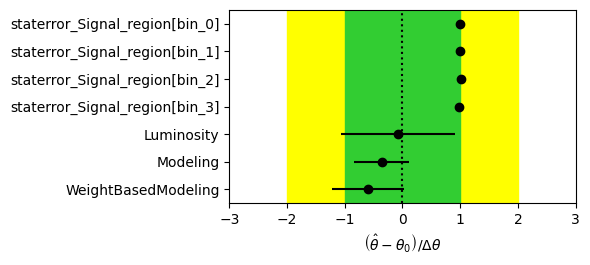

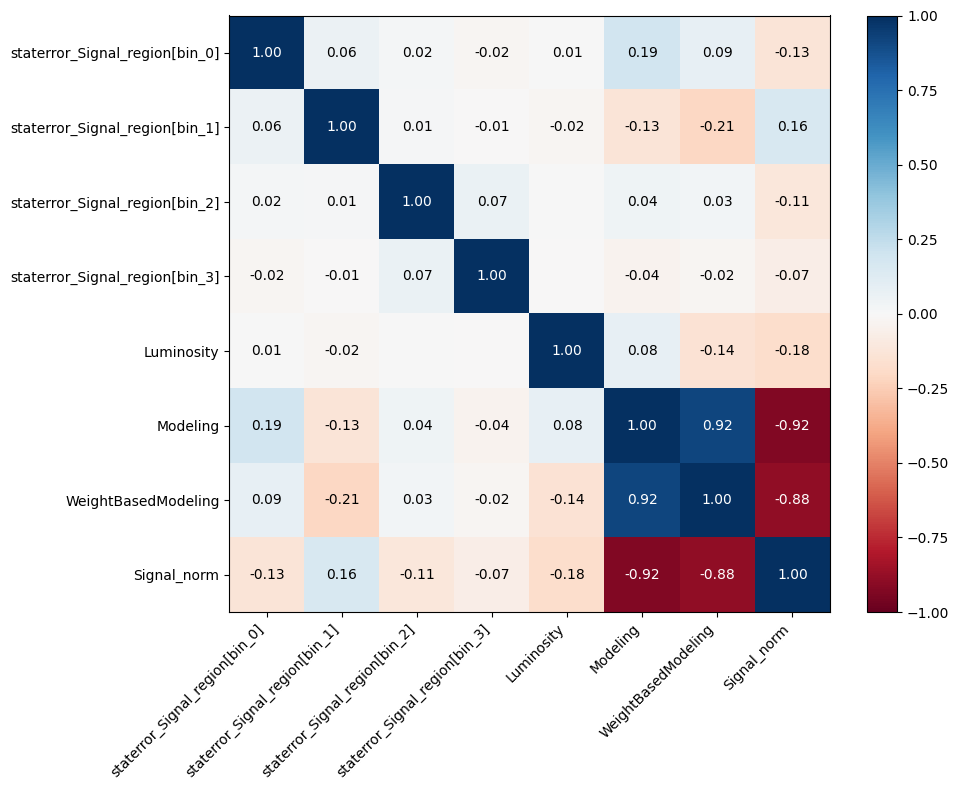

In [15]:
figure_folder = "figures/"
cabinetry.visualize.pulls(bestfit, uncertainty, labels, "figures/", exclude_list="Signal_norm")
cabinetry.visualize.correlation_matrix(corr_mat, labels, "figures/")

## Visualizing templates

What did we fit?
The `visualize` module also contains functionality to plot data/MC distributions (at the moment only pre-fit).

INFO - cabinetry.visualize - visualizing histogram


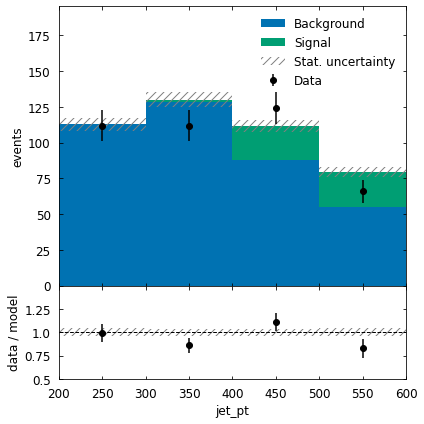

In [16]:
cabinetry.visualize.data_MC(
    cabinetry_config, figure_folder, prefit=True, method="matplotlib"
)